# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from RL_library import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## Sarsa + Neural Network

Initialize the parameters for training
-   Nerual Network Layer
-   Hyperparameters
-   Result Array

In [3]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...
## ----------------------------------------------------
### Xavier Initialize for W of each layer
W1 = np.random.randn(N_h,N_in) * np.sqrt(1 / (N_in))
b1 = np.zeros((N_h,))

W2 = np.random.randn(N_a,N_h) * np.sqrt(1 / (N_h))
b2 = np.zeros((N_a,))

### Adam Optimization Initialize
beta1=0.9
Adam_W1 = Adam(W1, beta1)
Adam_b1 = Adam(b1, beta1)
Adam_W2 = Adam(W2, beta1)
Adam_b2 = Adam(b2, beta1)
## ----------------------------------------------------

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 20 #100000 # THE NUMBER OF GAMES TO BE PLAYED 
N_perfCheck = 10 #Check the performance every N_perfCheck episodes

# SAVING VARIABLES
Episode = np.zeros([N_episodes//N_perfCheck, 1])
R_save = np.zeros([N_episodes//N_perfCheck, 1])
N_moves_save = np.zeros([N_episodes//N_perfCheck, 1])
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...


Training Q value following Sarsa

In [9]:
p = 0
for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    """
    Sarsa Algorithm
    1. Initialize S, X, ALLOWED_A
    """
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    """
    Sarsa Algorithm
    2. CHOOSE A_AGENT FROM S USING POLICY DERIVED FROM Q (EPSILON-GREEDY)
    """
    Qvalues, a_h = CalQvalues(X,W1,W2,b1,b2)
    a_agent, _ = EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon_f)
    
    """
    Q-Learning Algorithm
        Loop for each episode
    """
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        """
        Sarsa Algorithm
        3. TAKE ACTION A_AGENT, OBSERVE R, S_NEXT
        """
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

        """
        If the game is Done(Checkmate, Draw),
        Update the parameters of Neural Network lastly.
        """        
        if Done==1:

            # Back Propagation with ADAM Optimization
            # NOT CONSIDER X_NEXT

            # Compute the error signal
            e_n = np.zeros(np.shape(Qvalues))
            e_n[a_agent] = R-Qvalues[a_agent]

            # Backpropagation: output layer -> hidden layer
            # Activation Function : ReLu(Reactified Linear Function)
            delta2 = e_n
            dW2 = np.outer(delta2, a_h)
            db2 = delta2

            # Backpropagation: hidden layer -> input layer
            # Activation Function : ReLu(Reactified Linear Function)
            delta1 = np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X)
            db1 = delta1

            W2 += eta*Adam_W2.Compute(dW2)
            W1 += eta*Adam_W1.Compute(dW1)
            b2 += eta*Adam_b2.Compute(db2)
            b1 += eta*Adam_b1.Compute(db1)
            
            break
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
        """
        Sarsa Algorithm
        4. CHOOSE A_AGENT_NEXT FROM S_NEXT USING POLICY DERIVED FROM Q (EPSILON-GREEDY)
        """
        Qvalues_next, a_h = CalQvalues(X_next,W1,W2,b1,b2)
        a_agent_next, _ = EpsilonGreedy_Policy(Qvalues_next, allowed_a_next, epsilon_f)

        """
        Sarsa Algorithm
        5. UPDATE Q VALUES
        """
        # Compute the delta of Sarsa
        e_n = np.zeros(np.shape(Qvalues))
        e_n[a_agent] = R+gamma*Qvalues_next[a_agent_next]-Qvalues[a_agent]
        
        # Backpropagation: output layer -> hidden layer
        # Activation Function : ReLu(Reactified Linear Function)
        delta2 = e_n
        dW2 = np.outer(delta2, a_h)
        db2 = delta2

        # Backpropagation: hidden layer -> input layer
        # Activation Function : ReLu(Reactified Linear Function)
        delta1 = np.dot(W2.T, delta2)
        dW1 = np.outer(delta1,X)
        db1 = delta1

        W2 += eta*Adam_W2.Compute(dW2)
        W1 += eta*Adam_W1.Compute(dW1)
        b2 += eta*Adam_b2.Compute(db2)
        b1 += eta*Adam_b1.Compute(db1)
        
        """
        Q-Learning Algorithm
        6. UPDATE S, X, A_AGENT
        """  
        S=np.copy(S_next)
        X=np.copy(X_next)
        Qvalues, a_h = CalQvalues(X,W1,W2,b1,b2)
        a_agent=a_agent_next

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
   
    if ((n+1)%N_perfCheck==0):
        print(n+1,': Agent Performance Check, START')
        R_perf, N_moves_perf = PerformanceCheck(env,W1,W2,b1,b2,100)
        print('Agent Performance Check, Average reward:',R_perf,'Number of steps: ',N_moves_perf)
        print('-------------------------------------------------------------------')

        Episode[p] = n+1
        R_save[p] = np.copy(R_perf)
        N_moves_save[p] = np.copy(N_moves_perf)

        p += 1

10 : Agent Performance Check, START


100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


Agent Performance Check, Average reward: 0.34 Number of steps:  50.13
-------------------------------------------------------------------
20 : Agent Performance Check, START


100%|██████████| 100/100 [00:03<00:00, 30.77it/s]

Agent Performance Check, Average reward: 0.4 Number of steps:  31.2
-------------------------------------------------------------------


In [18]:
R_perf, N_moves_perf = PerformanceCheck(env,W1,W2,b1,b2,100)
print('Agent Performance Check, Average reward:',R_perf,'Number of steps: ',N_moves_perf)
        

Random_Agent, Average reward: 0.37479 Number of steps:  12.4057


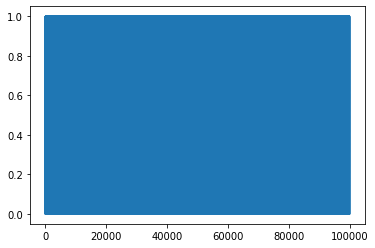

In [19]:
plt.plot(R_save)

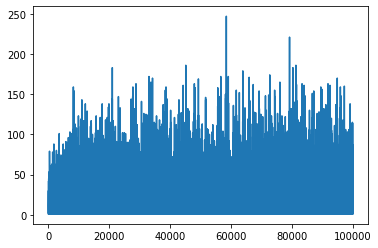

In [20]:
plt.plot(N_moves_save)

In [21]:
np.savetxt("R_Save_epsilon_0",R_save)

In [23]:
np.savetxt("N_moves_save_epsilon_0",N_moves_save)